# Test4 with Benchmarking

In [1]:
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, accuracy_score
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import Test4, MLR, AbstractSimulator

In [3]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Test4
    run_names: list = None
    suffix: str = "_test4"

conf = Config()

Text(0.5, 1.0, 'Test-59048')

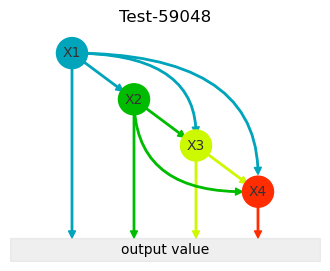

In [4]:
fig, ax = plt.subplots(figsize=(4, 3))

conf.simulator(edge_assignsment=[1] * 10).plot(ax=ax)
ax.set_title(conf.simulator(edge_assignsment=[1] * 10, model_id=3 ** 10 - 1).name)

# if conf.savefig:
#     fig.savefig(f"{conf.out}/sim_model{conf.suffix}", **kwarg_savefig)

In [5]:
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

conditions = dict(
    ff=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
    pb=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
    cloo=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
)

designs = dict(
    ff=FullFactorial,
    pb=PlackettBurman,
    cloo=CLOO,
)

In [6]:
for k, models in tqdm(conditions.items(), total=3):
    [
        m.simulate(
            design=designs[k], n_rep=3
        ) for (i, m) in tqdm(enumerate(models), total=len(edges))
    ]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

In [7]:
ground_truth = [
    MLR(v).summary(
        anova=True, dtype=int
    ) for v in tqdm(conditions["ff"], total=len(edges))
]

pb_k, cloo_k = [], []
pb_dd, cloo_dd = [], []

def kappa(res, gt):
    if gt.unique().size == 1:
        f = lambda res, gt: accuracy_score(res, gt)
    else:
        f = lambda res, gt: cohen_kappa_score(res, gt, weights="linear")
    return np.nan if res.isna().all() else f(res, gt)

# kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for (pb, cloo, gt) in tqdm(zip(conditions["pb"], conditions["cloo"], ground_truth), total=len(edges)):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]

  0%|          | 0/59049 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

In [1143]:
def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

In [1141]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
})

dat.to_feather(f"{conf.out}/esm{conf.suffix}.feather")

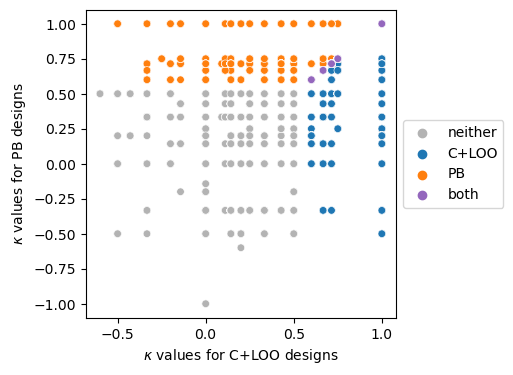

In [1142]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    dat.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    palette=[".7", "C0", "C1", "C4"],
    s=30, 
    # linewidth=0
)

ax.set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="$\kappa$ values for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

if conf.savefig:
    fig.savefig(f"{conf.out}/kappa_scatter{conf.suffix}", **kwarg_savefig)

In [1119]:
def n_pathways(arr) -> int:
    return np.abs(arr)[:4].sum()

def n_edges(arr) -> int:
    return np.abs(arr)[4:].sum()

def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

def n_pos(arr):
    return (arr[4:] == 1).sum()

def n_eff(arr): 
    return np.array([
        (arr[4] != 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] != 0) & (arr[3] != 0),
        (arr[7] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] != 0) & (arr[3] != 0),
        (arr[9] != 0) & (arr[3] != 0),
    ]).sum()

def n_effpos(arr):
    return np.array([
        (arr[4] > 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] > 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] > 0) & (arr[3] != 0),
        (arr[7] > 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] > 0) & (arr[3] != 0),
        (arr[9] > 0) & (arr[3] != 0),
    ]).sum()

def max_loading(arr):
    load = np.array([
        0,
        (arr[(4),] != 0).sum(),
        (arr[(5, 7),] != 0).sum() + (arr[(4, 7),] != 0).all(),
        (arr[(6, 8, 9),] != 0).sum() + (arr[(7, 9),] != 0).all() + (arr[(5, 9),] != 0).all() + (arr[(4, 7, 9),] != 0).all(),
    ])
    return  (np.abs(arr)[:4] * load).max()

def max_density(arr):
    return max_loading(arr) / n_eff(arr) if n_eff(arr) != 0 else 0

def cai(arr) -> float:
    ep = n_pos(arr)
    e = n_edges(arr)
    e_theoretical = len(arr[4:])

    e_coverage = e / e_theoretical
    positivity = 0 if e == 0 else ep / e

    return np.mean([e_coverage, positivity])

def cai2(arr) -> float:
    ep = n_effpos(arr)
    e = n_eff(arr)
    e_theoretical = len(arr[4:])

    e_coverage = e / e_theoretical
    positivity = 0 if e == 0 else ep / e

    return np.mean([e_coverage, positivity])

def cai3(arr) -> float:
    return (cai2(arr) * 2 + max_density(arr)) / 3

In [1120]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "n_edges": list(map(lambda x: np.abs(x[4:]).sum(), edges)),
    "n_pos": list(map(n_pos, edges)),
    "n_path": list(map(n_pathways, edges)),
    "n_eff": list(map(n_eff, edges)),
    "eff": list(map(effectivity, edges)),
    "load": list(map(max_loading, edges)),
    "dens": list(map(max_density, edges)),
    "cai": list(map(cai, edges)),
    "cai2": list(map(cai2, edges)),
    "cai3": list(map(cai3, edges)),
})

In [1121]:
feat = [
    "n_edges",
    "n_pos",
    "n_path",
    "n_eff",
    "eff",
    "load",
    "dens",
    "cai",
    "cai2",
    "cai3"
]

In [1122]:
corr = dat.loc[:, ["cloo", "pb"] + feat].corr(method="spearman")
corr

# fig, ax = plt.subplots(figsize=(3, 3))

# sns.heatmap(
#     corr,
#     vmax=1, vmin=-1, cmap="coolwarm", square=True, fmt=".2f", annot=True
# )

# ax.set_xticklabels([
#     "$\kappa$\n(C+LOO)", "$\kappa$\n(PB)", "$|E|$", "$|P|$", "$|E_{-}|$"
# ])
# ax.set_yticklabels([
#     "$\kappa$\n(C+LOO)", "$\kappa$\n(PB)", "$|E|$", "$|P|$", "$|E_{-}|$"
# ]);

,cloo,pb,n_edges,n_pos,n_path,n_eff,eff,load,dens,cai,cai2,cai3
cloo,1.000000,0.034275,0.019684,0.087483,-0.168749,-0.213362,-0.264318,-0.235372,-0.125915,0.081795,-0.044249,-0.073241
pb,0.034275,1.000000,-0.153160,-0.144706,-0.110630,-0.200723,-0.147307,-0.202255,-0.152882,-0.152479,-0.235251,-0.238857
n_edges,0.019684,-0.153160,1.000000,0.484293,0.000000,0.575697,0.075591,0.577358,0.230651,0.595237,0.403512,0.436978
n_pos,0.087483,-0.144706,0.484293,1.000000,0.000000,0.285325,0.037872,0.285045,0.109762,0.957667,0.675104,0.620898
n_path,-0.168749,-0.110630,0.000000,0.000000,1.000000,0.448702,0.569182,0.374418,0.043120,0.000000,0.308851,0.242055
n_eff,-0.213362,-0.200723,0.575697,0.285325,0.448702,1.000000,0.810736,0.937593,0.245690,0.341015,0.671685,0.643701
eff,-0.264318,-0.147307,0.075591,0.037872,0.569182,0.810736,1.000000,0.734904,0.153495,0.047046,0.538231,0.478278
load,-0.235372,-0.202255,0.577358,0.285045,0.374418,0.937593,0.734904,1.000000,0.510324,0.344228,0.637482,0.722246
dens,-0.125915,-0.152882,0.230651,0.109762,0.043120,0.245690,0.153495,0.510324,1.000000,0.145025,0.293757,0.561016
cai,0.081795,-0.152479,0.595237,0.957667,0.000000,0.341015,0.047046,0.344228,0.145025,1.000000,0.695215,0.649795


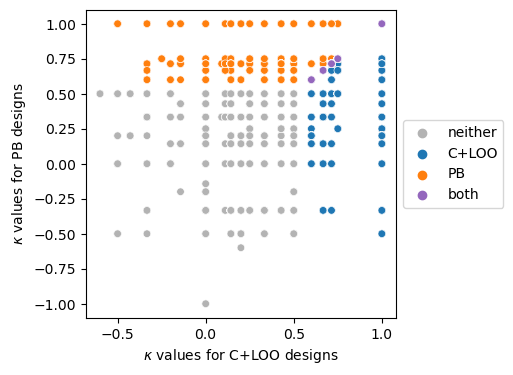

In [872]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    dat.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    palette=[".7", "C0", "C1", "C4"],
    s=30, 
    # linewidth=0
)

ax.set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="$\kappa$ values for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

if conf.savefig:
    fig.savefig(f"{conf.out}/kappa_scatter{conf.suffix}", **kwarg_savefig)

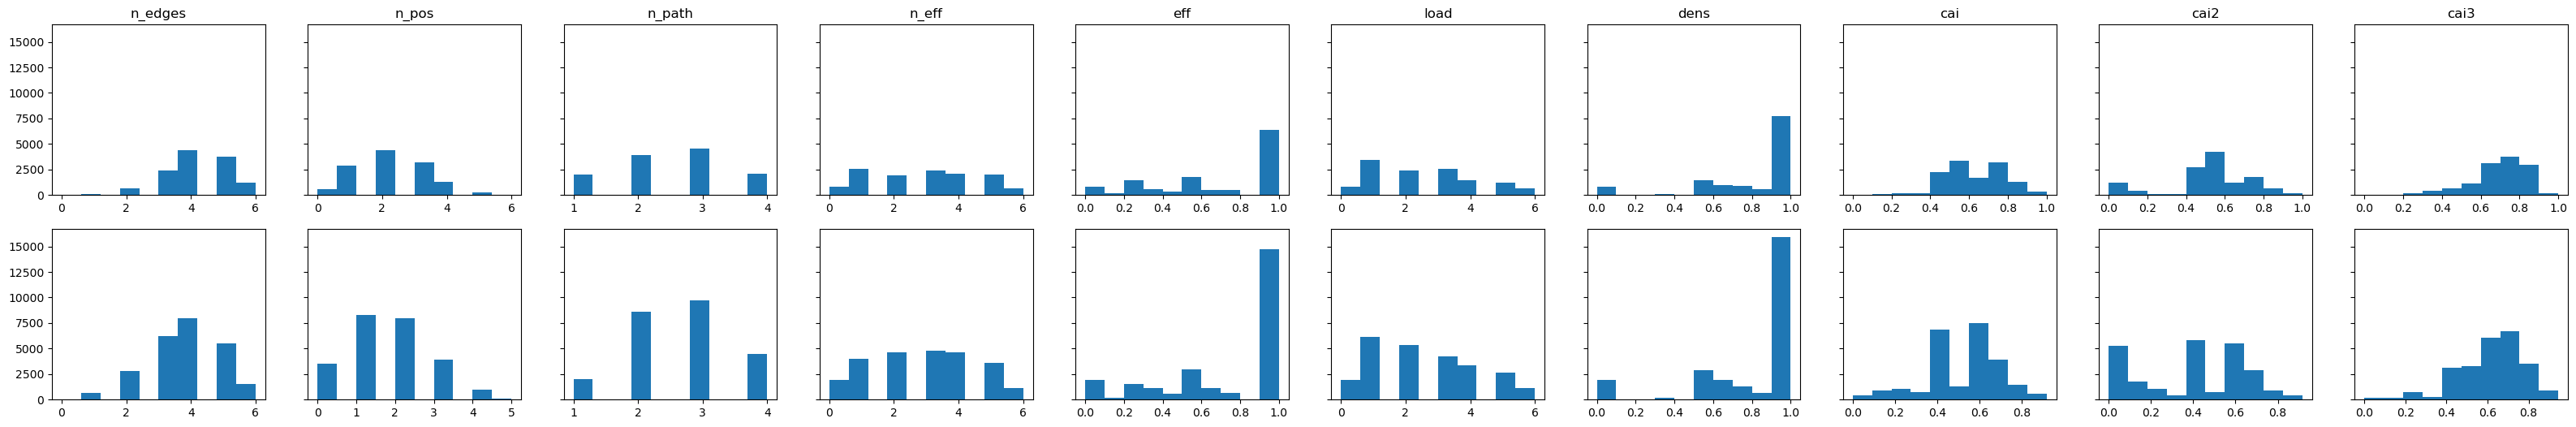

In [1115]:
fig, ax = plt.subplots(2, len(feat), figsize=(4 * len(feat), 6), sharey=True)

for i, k in enumerate(feat):
    ax[0, i].hist(dat[dat.loc[:, ""] == "C+LOO"].loc[:, k])
    ax[1, i].hist(dat[dat.loc[:, ""] == "PB"].loc[:, k])
    ax[0, i].set_title(k)

In [1096]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

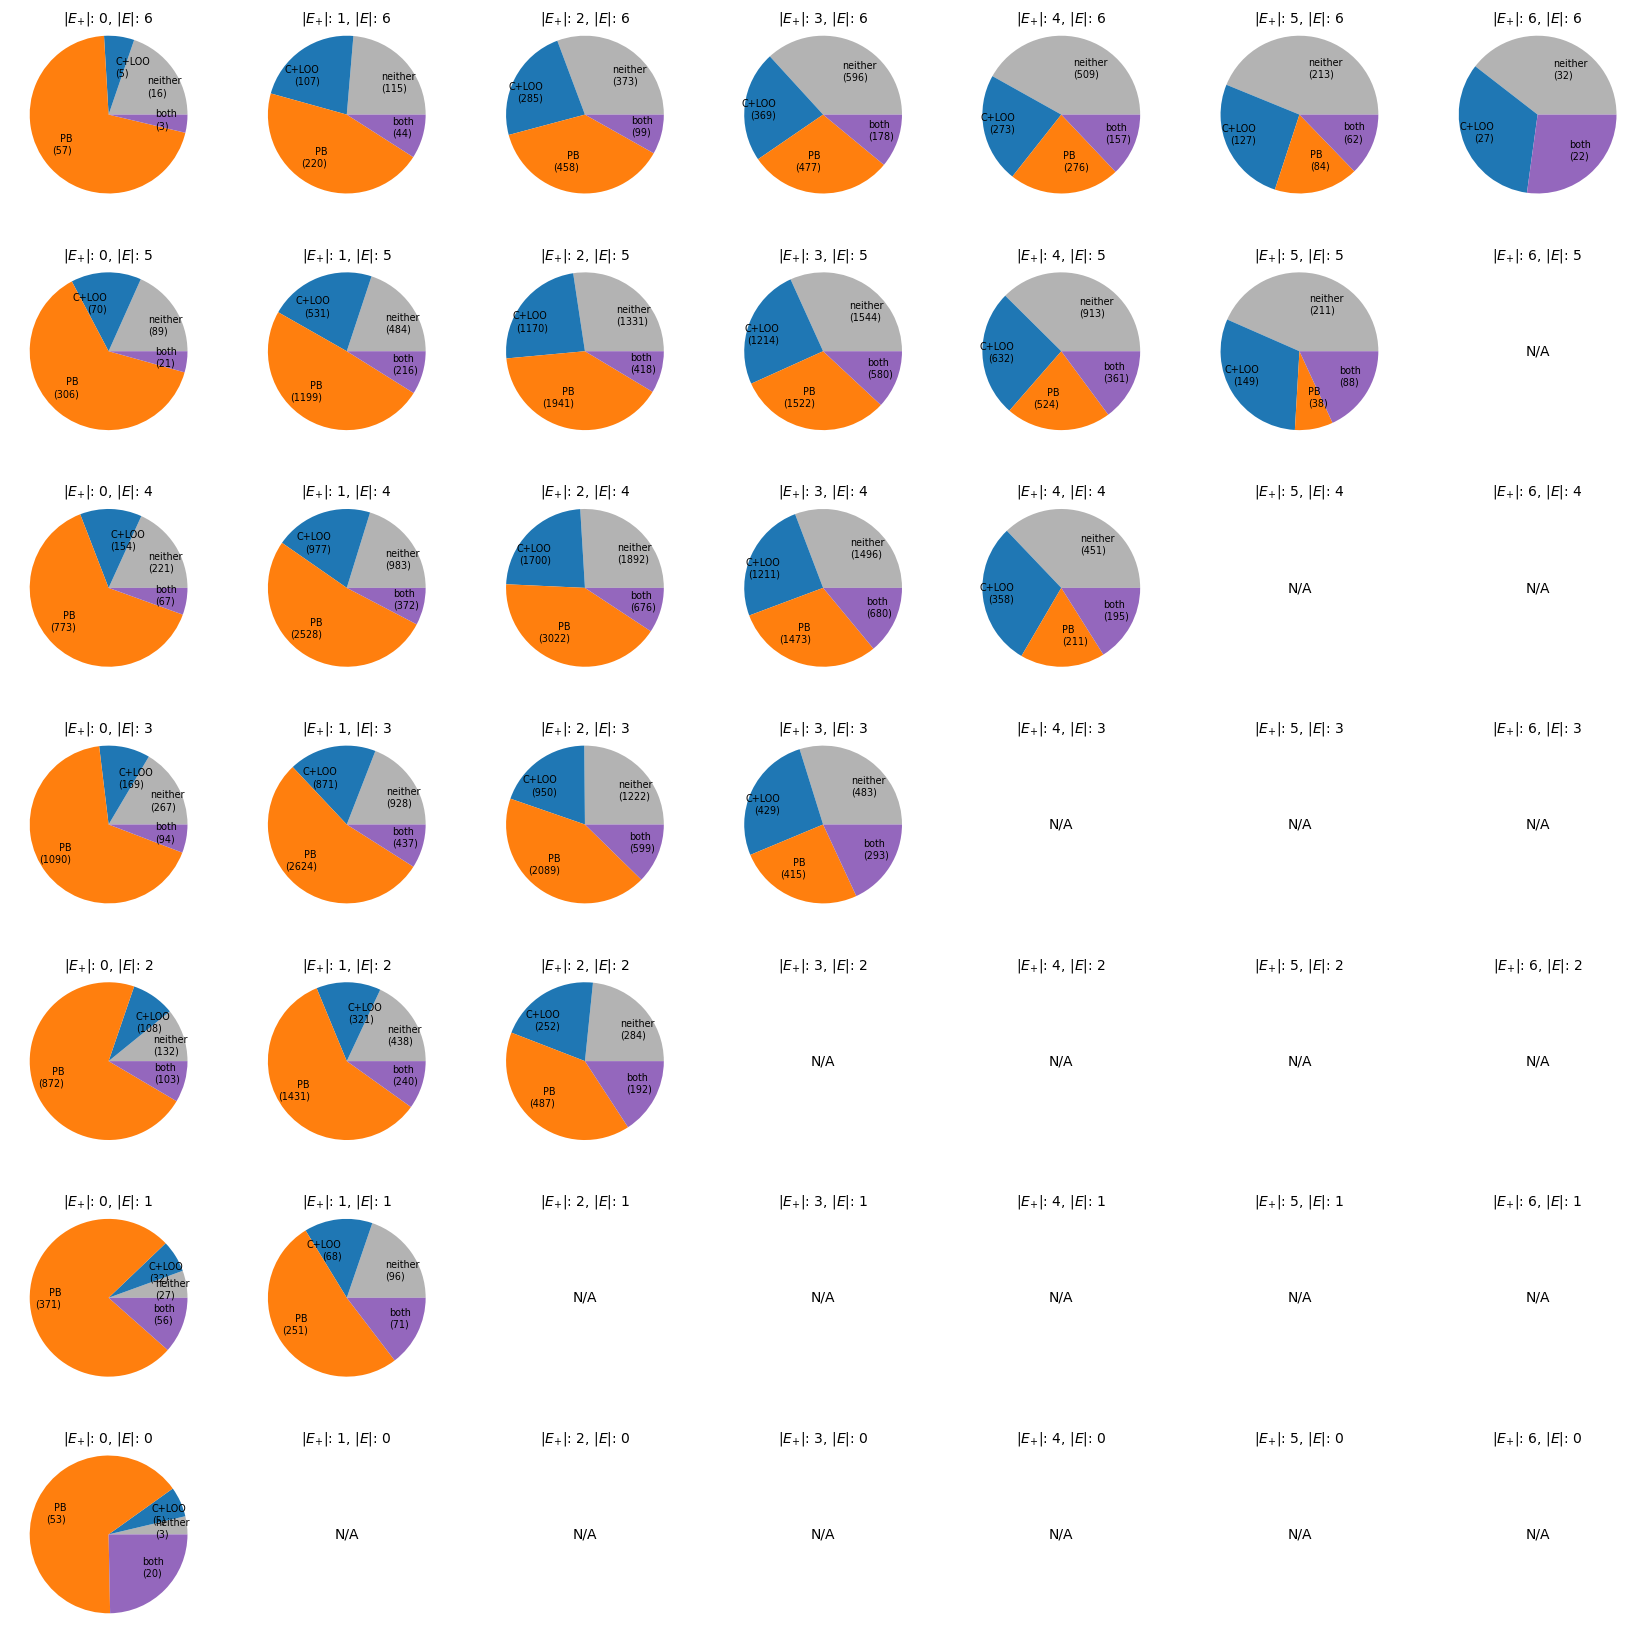

In [875]:
key_r, key_c = "n_edges", "n_pos"
label_r, label_c = "$|E|$", "$|E_{+}|$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")
        # a.text(
        #     0, 1.1, 
        #     f"${latexify(key_c)}$: {i % ncol}, ${latexify(key_r)}$: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )

if conf.savefig:
    fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

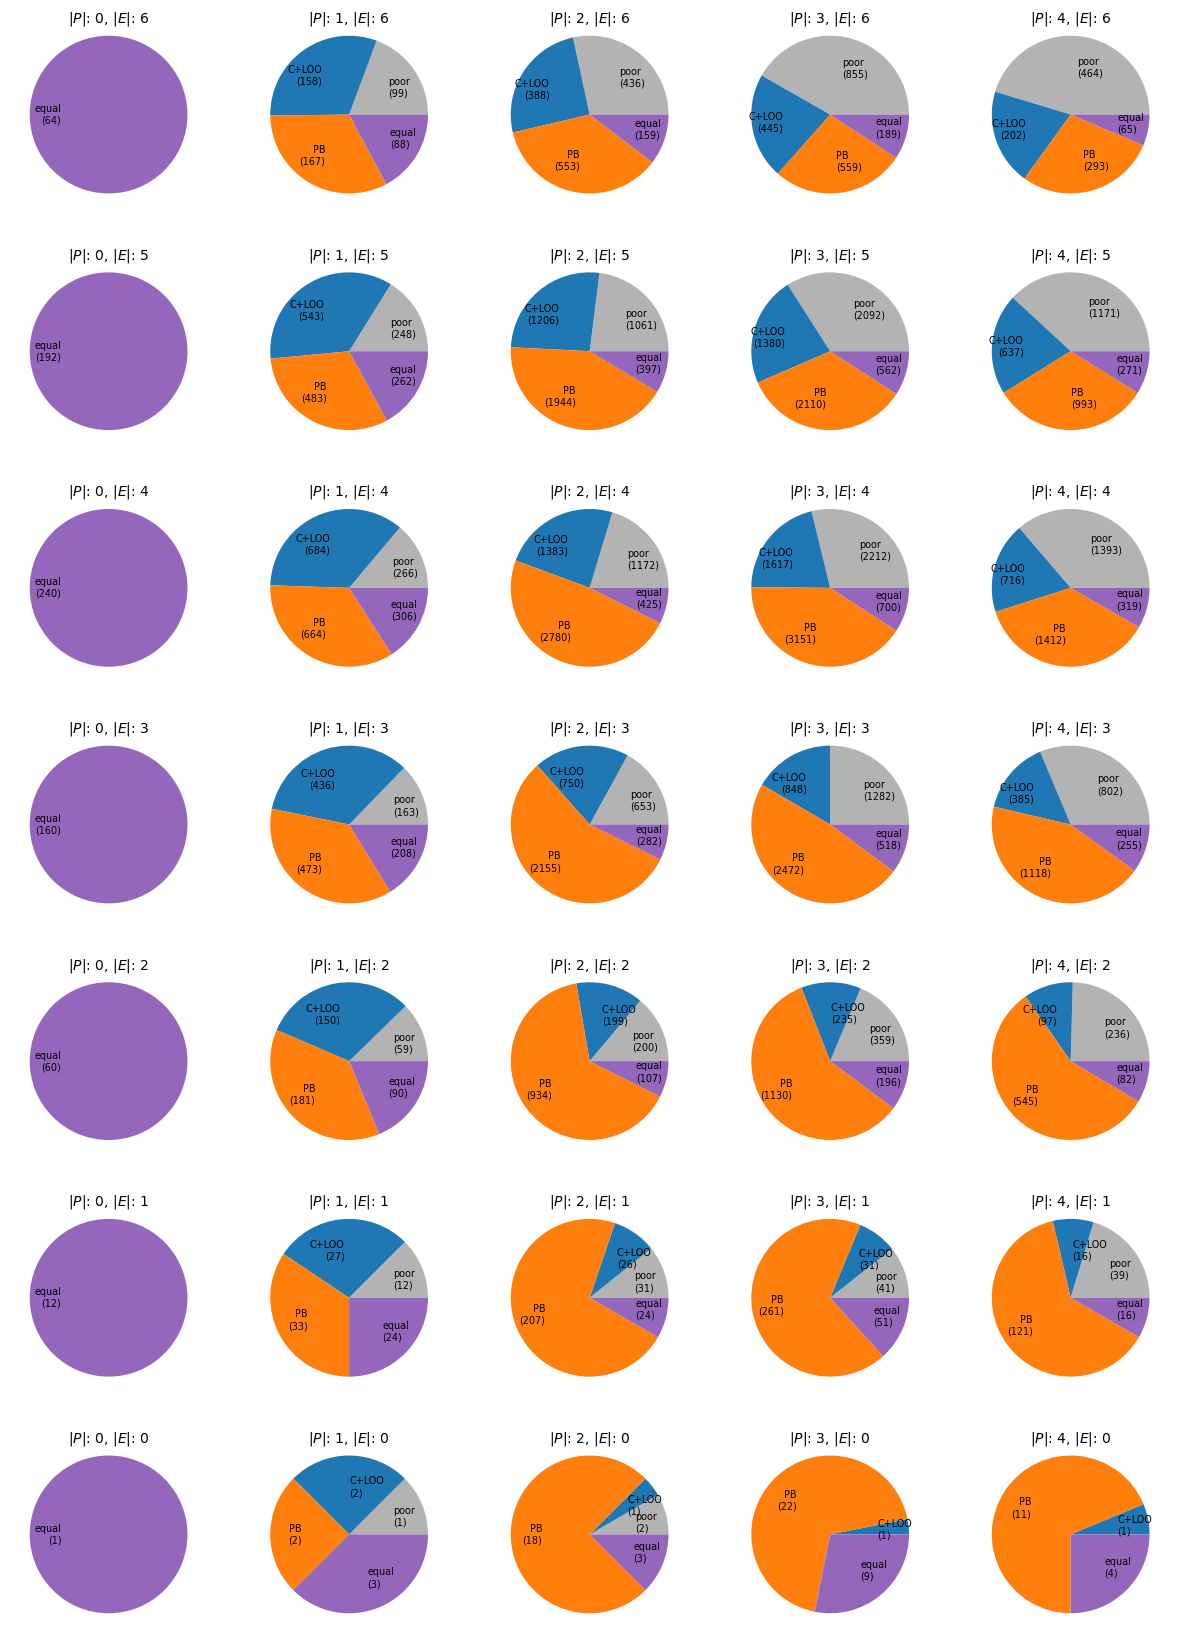

In [876]:
key_r, key_c = "n_edges", "n_path"
label_r, label_c = "$|E|$", "$|P|$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

if conf.savefig:
    fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

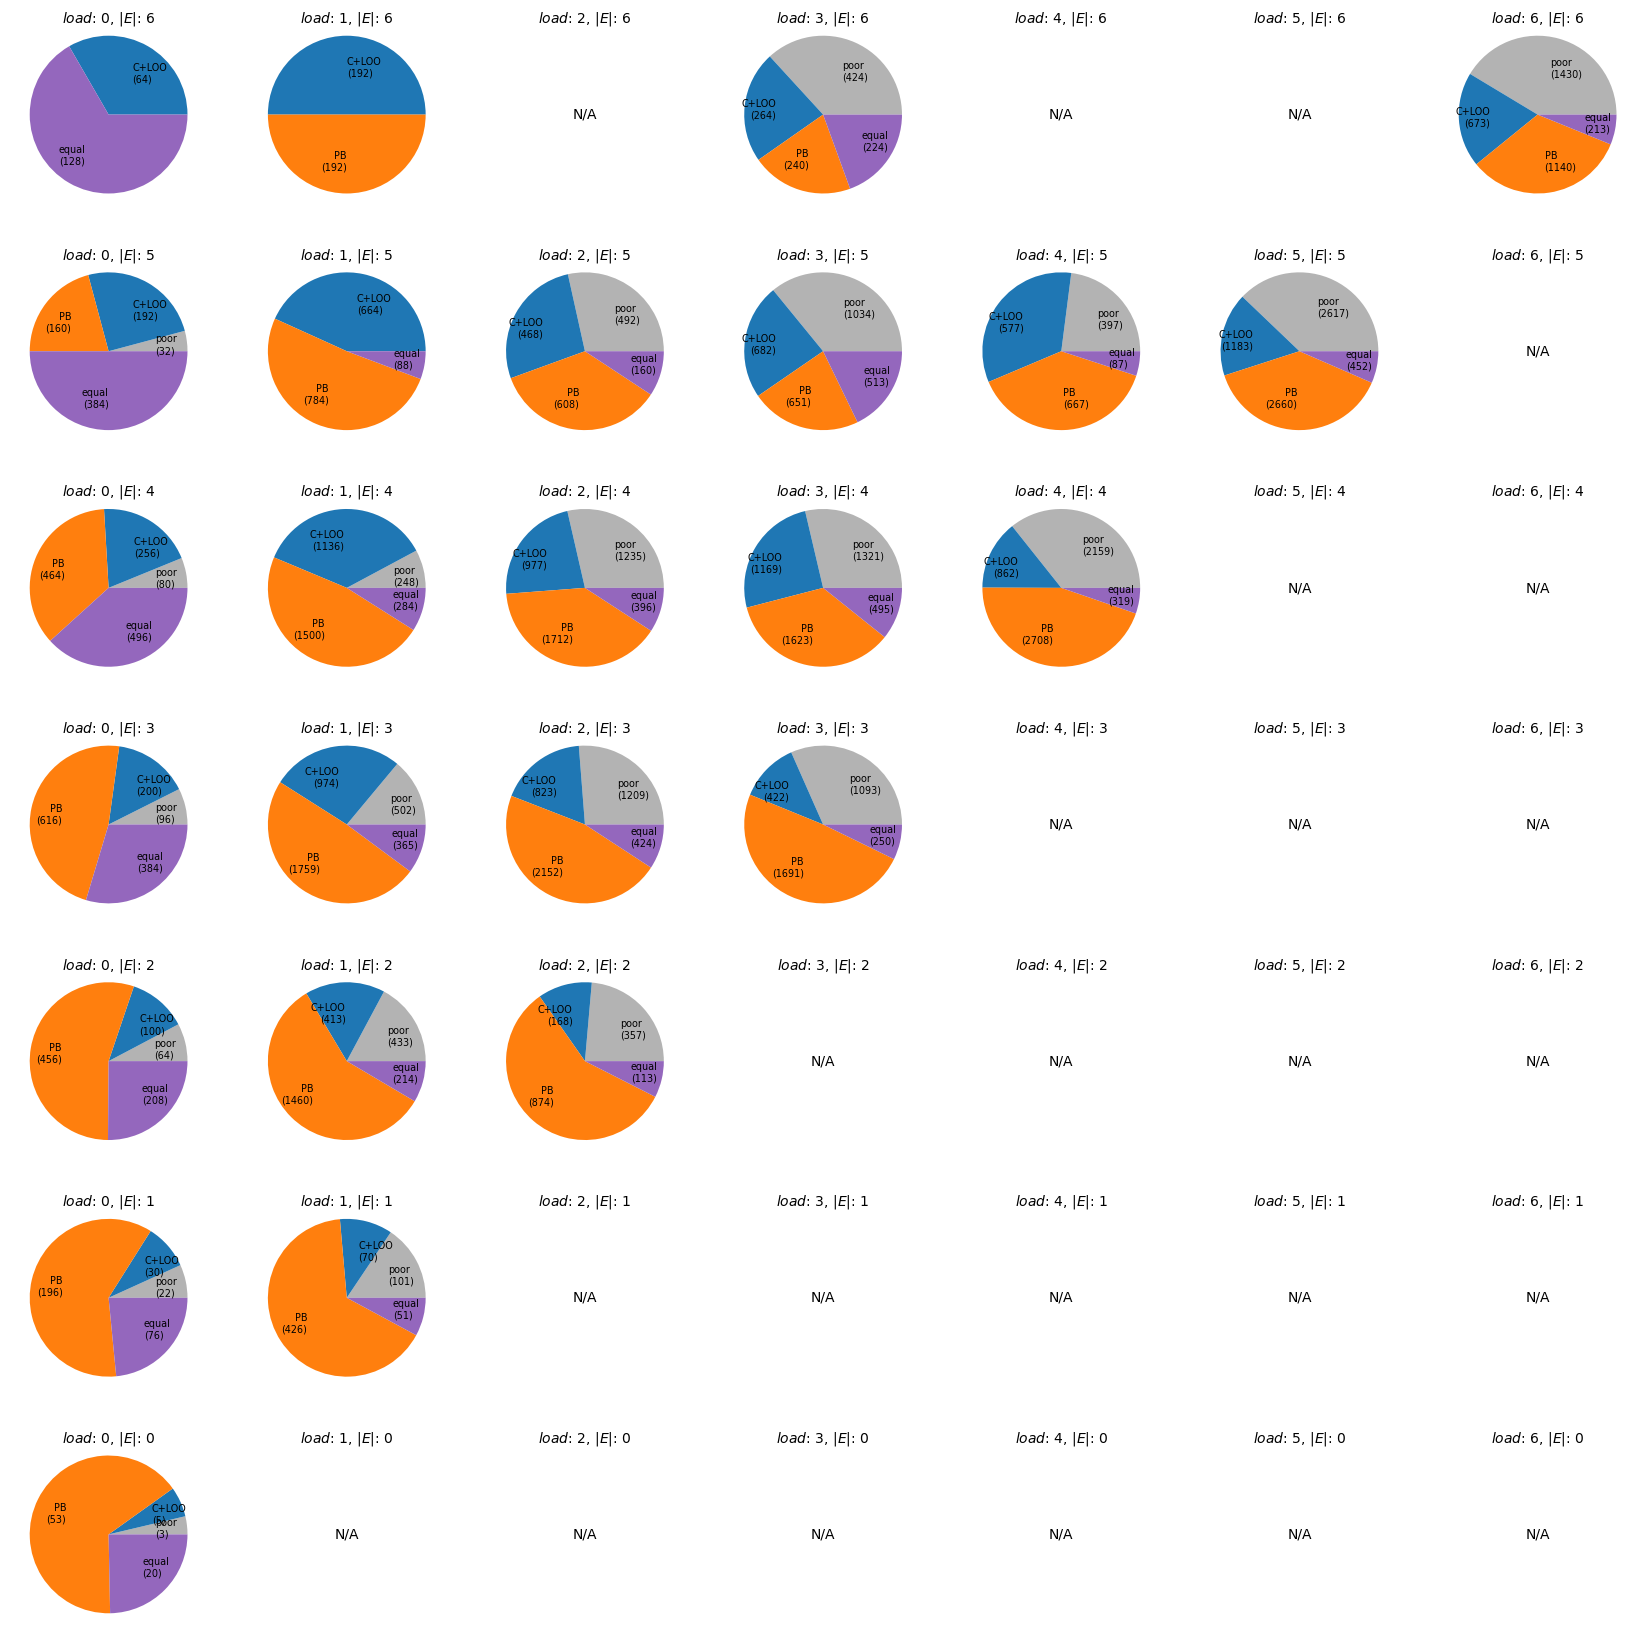

In [1099]:
key_r, key_c = "n_edges", "load"
label_r, label_c = "$|E|$", "$load$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

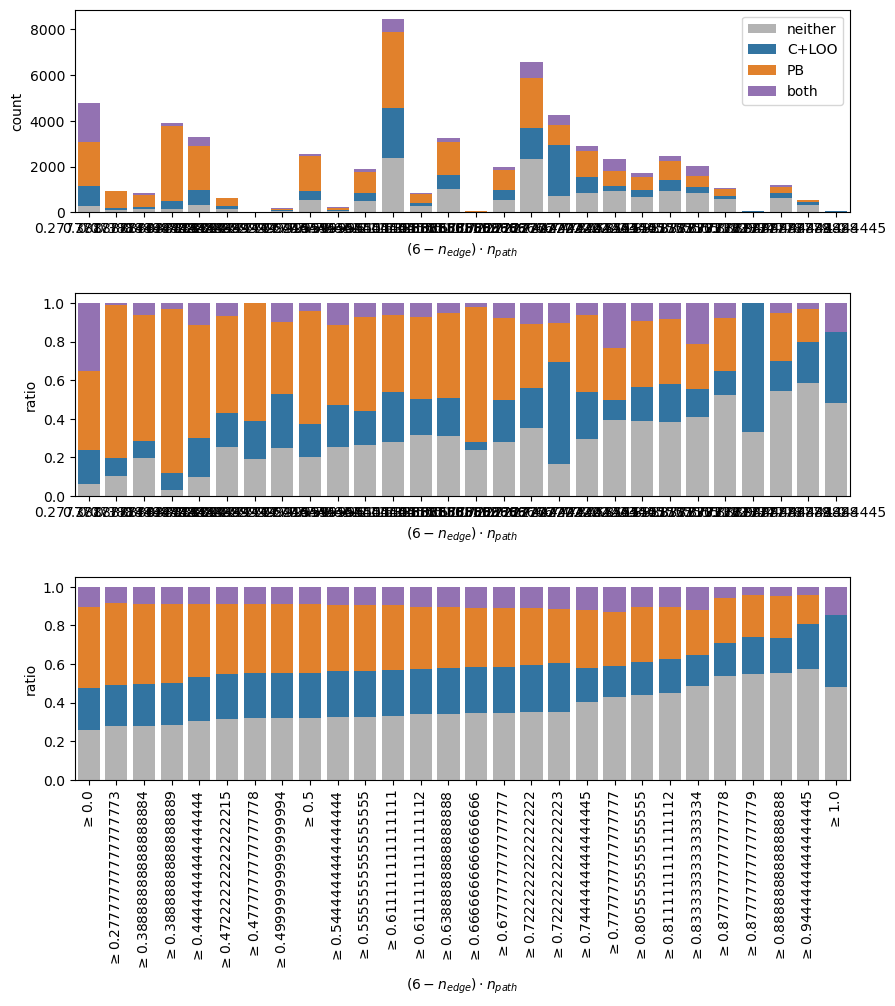

In [1123]:
df = stacked_tally(dat, "cai3", "", stack_key="v", ratio=False)
df2 = stacked_tally(dat, "cai3", "", stack_key="v", ratio=True)
df3 = stacked_tally(dat, "cai3", "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=.4)

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.barplot(
        data=df[df.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
ax[2].xaxis.set_tick_params(rotation=90)

[
    a.set(
        xlabel=r"$(6-n_{edge})\cdot n_{path}$",
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

# if conf.savefig:
    # fig.savefig(f"{conf.out}/bar_n_edges_n_path{conf.suffix}", **kwarg_savefig)

[Text(0.5, 0, 'CAI'), Text(0, 0.5, 'class ratio ($CAI=x$)')]

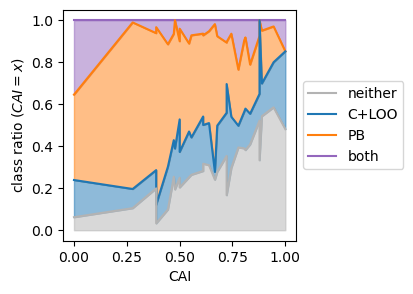

In [1124]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.lineplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="CAI", ylabel="class ratio ($CAI=x$)")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_cai{conf.suffix}", **kwarg_savefig)

[Text(0.5, 0, 'CAI'), Text(0, 0.5, 'class ratio ($CAI\\geq x$)')]

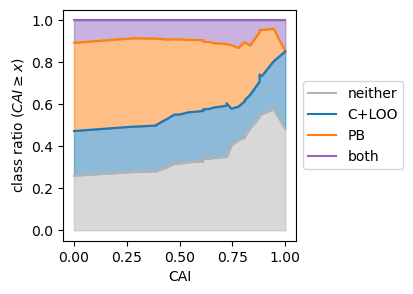

In [1125]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.lineplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="CAI", ylabel="class ratio ($CAI\geq x$)")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_cai_geq{conf.suffix}", **kwarg_savefig)

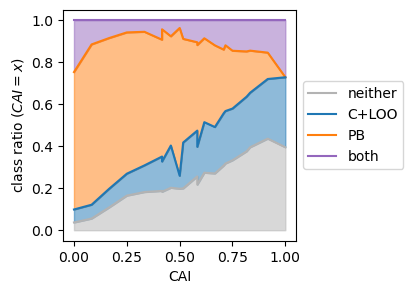

In [917]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.lineplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="CAI", ylabel="class ratio ($CAI=x$)")

if conf.savefig:
    fig.savefig(f"{conf.out}/bar_cai{conf.suffix}", **kwarg_savefig)

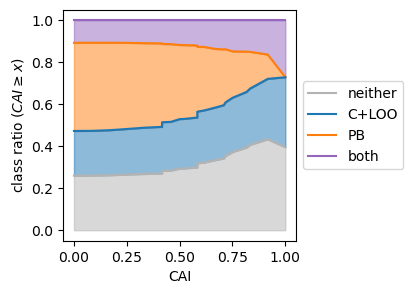

In [918]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.lineplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="CAI", ylabel="class ratio ($CAI\geq x$)")

if conf.savefig:
    fig.savefig(f"{conf.out}/bar_cai_geq{conf.suffix}", **kwarg_savefig)

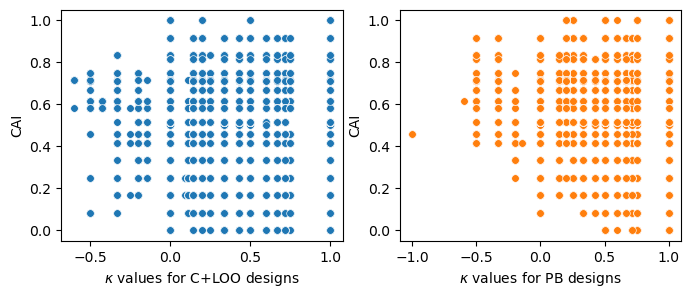

In [947]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# plt.subplots_adjust(hspace=.3)

sns.scatterplot(
    dat, x="cloo", y="cai", 
    s=30, ax=ax[0], color="C0"
    # linewidth=0
)

ax[0].set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="CAI"
)

sns.scatterplot(
    dat, x="pb", y="cai", 
    s=30, ax=ax[1], color="C1"
    # linewidth=0
)

ax[1].set(
    xlabel="$\kappa$ values for PB designs", 
    ylabel="CAI"
)


if conf.savefig:
    fig.savefig(f"{conf.out}/kappa_vs_cai{conf.suffix}", **kwarg_savefig)

<AxesSubplot: xlabel='cai2', ylabel='cai3'>

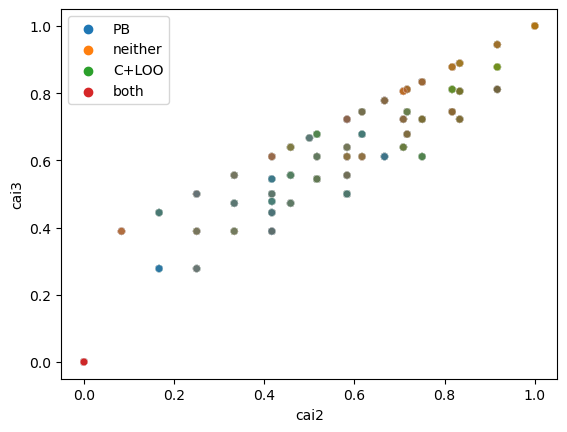

In [1129]:
sns.scatterplot(
    dat, x="cai2", y="cai3", 
    s=30, hue="", alpha=.1
    # linewidth=0
)

In [1130]:
from sklearn.manifold import TSNE

In [1133]:
dat.loc[:, feat]

,n_edges,n_pos,n_path,n_eff,eff,load,dens,cai,cai2,cai3
0,6,0,4,6,1.0,6,1.00,0.500000,0.500000,0.666667
1,5,0,4,5,1.0,3,0.60,0.416667,0.416667,0.477778
2,6,1,4,6,1.0,6,1.00,0.583333,0.583333,0.722222
3,5,0,4,5,1.0,5,1.00,0.416667,0.416667,0.611111
4,4,0,4,4,1.0,3,0.75,0.333333,0.333333,0.472222
...,...,...,...,...,...,...,...,...,...,...
59044,4,4,4,4,1.0,3,0.75,0.833333,0.833333,0.805556
59045,5,5,4,5,1.0,5,1.00,0.916667,0.916667,0.944444
59046,6,5,4,6,1.0,6,1.00,0.916667,0.916667,0.944444
59047,5,5,4,5,1.0,3,0.60,0.916667,0.916667,0.811111


In [1134]:
tsne = TSNE(random_state=0).fit_transform(dat.loc[:, feat])

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: xlabel='x', ylabel='y'>

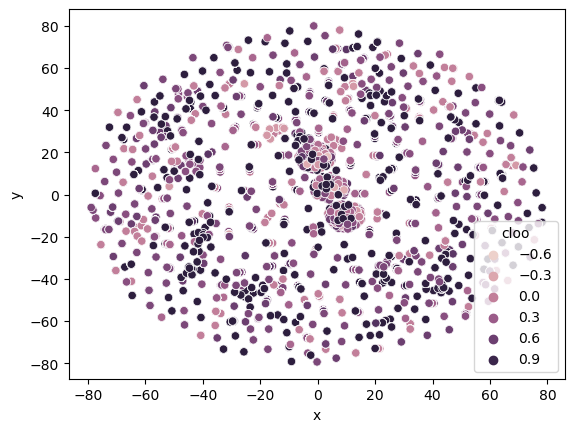

In [1137]:
df_tsne = pd.DataFrame(tsne, columns=["x", "y"])

sns.scatterplot(
    data=df_tsne,
    x="x", y="y", hue=dat.loc[:, "cloo"]
)

In [912]:
line_idx

3

In [911]:
k

'both'

key_r, key_c = "n_edges", "n_path"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"${latexify(key_r)}$: {nrow - 1 - i // ncol}, ${latexify(key_c)}$: {i % ncol}", ha="center", va="bottom")
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

if conf.savefig:
    fig.savefig(f"{conf.out}/pie_{key_r}_{key_c}{conf.suffix}", **kwarg_savefig)

key_r, key_c = "n_edges", "n_neg3"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"${latexify(key_r)}$: {nrow - 1 - i // ncol}, ${latexify(key_c)}$: {i % ncol}", ha="center", va="bottom")
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

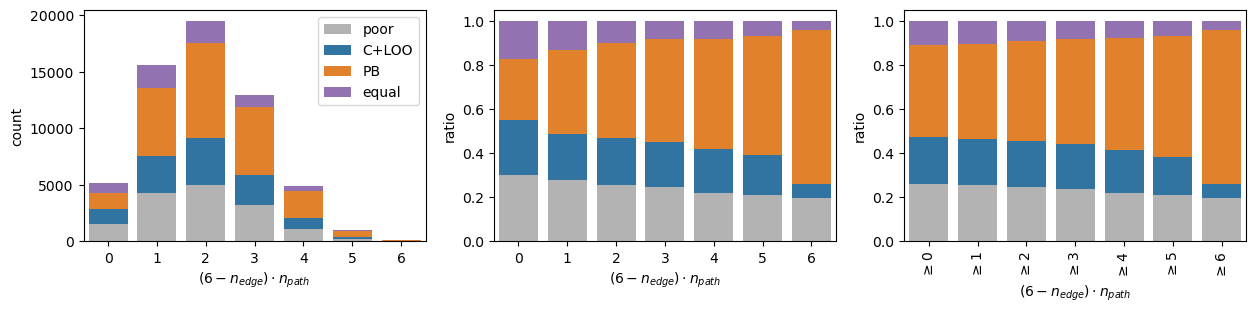

In [745]:
kw = "n_neg2"

df = stacked_tally(dat, kw, "", stack_key="v", ratio=False)
df2 = stacked_tally(dat, kw, "", stack_key="v", ratio=True)
df3 = stacked_tally(dat, kw, "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
plt.subplots_adjust(wspace=.2)

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.barplot(
        data=df[df.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
ax[2].xaxis.set_tick_params(rotation=90)

[
    a.set(
        xlabel=r"$(6-n_{edge})\cdot n_{path}$",
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

if conf.savefig:
    fig.savefig(f"{conf.out}/bar_n_edges_n_path{conf.suffix}", **kwarg_savefig)

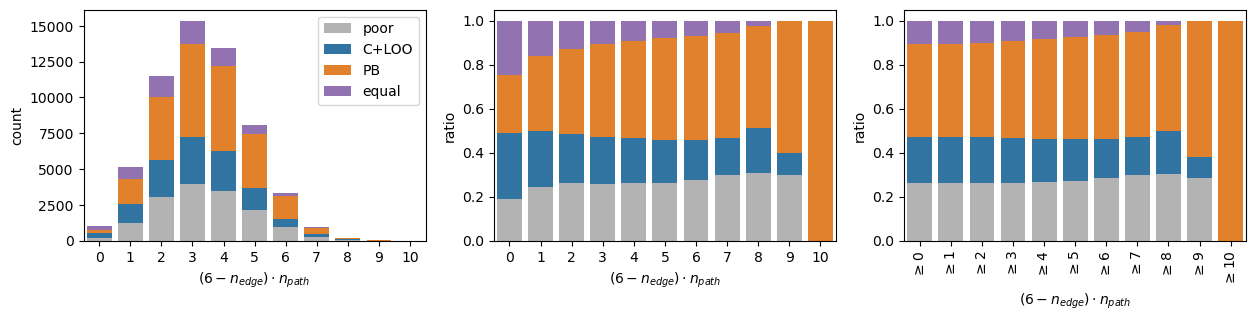

In [746]:
kw = "n_neg1"

df = stacked_tally(dat, kw, "", stack_key="v", ratio=False)
df2 = stacked_tally(dat, kw, "", stack_key="v", ratio=True)
df3 = stacked_tally(dat, kw, "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
plt.subplots_adjust(wspace=.2)

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.barplot(
        data=df[df.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
ax[2].xaxis.set_tick_params(rotation=90)

[
    a.set(
        xlabel=r"$(6-n_{edge})\cdot n_{path}$",
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

if conf.savefig:
    fig.savefig(f"{conf.out}/bar_n_edges_n_path{conf.suffix}", **kwarg_savefig)

In [ ]:
dat[(dat.loc[:, "n_path"] < 3) & (dat.loc[:, "n_sep"] < 3) & (dat.loc[:, "n_edges"] > 5)].loc[:, "vl"].value_counts()

PB       720
C+LOO    546
poor     535
equal    311
Name: vl, dtype: int64

In [ ]:
dat[(dat.loc[:, "n_edges"] == 0)].loc[:, ""].value_counts()

PB       40
good     35
poor      5
C+LOO     1
Name: , dtype: int64

In [ ]:
dat[(dat.loc[:, "feat"] == 12)].loc[:, "vl"]

27035       PB
27047     poor
27116    C+LOO
27128     poor
27143    C+LOO
         ...  
31905     poor
31920       PB
31932    equal
32001     poor
32013    equal
Name: vl, Length: 120, dtype: object

In [999]:
effectivity(edges[27035])

1.0

In [1001]:
edges[27035]

array([ 0,  0, -1,  0, -1, -1,  1, -1,  1,  1])

In [1002]:
n_edges(edges[27035])

6

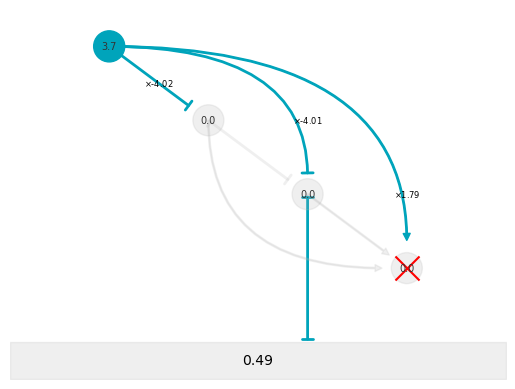

In [1000]:
fig, ax = plt.subplots()

models[27035].plot(ax)

In [483]:
dat[(dat.loc[:, "n_edges"] == 0)].loc[:, "vl"]

364      equal
1093     equal
1822     C+LOO
2551     equal
3280        PB
         ...  
55768       PB
56497    equal
57226       PB
57955    equal
58684    equal
Name: vl, Length: 81, dtype: object

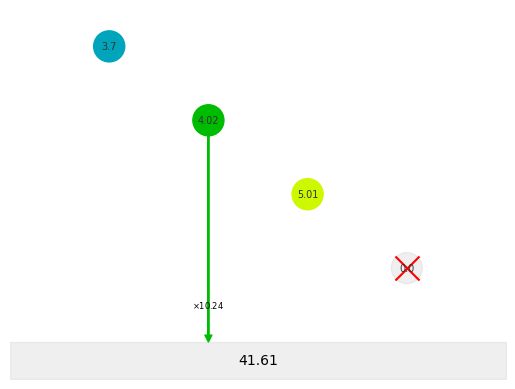

In [178]:
fig, ax = plt.subplots()

models[36085].plot(ax)

In [155]:
dat[dat.loc[:, "feat"] >= 6].loc[:, ""].value_counts()

PB       2397
C+LOO    1545
poor     1467
good      967
Name: , dtype: int64

In [160]:
dat[dat.loc[:, "feat"] >= 8].loc[:, ""].value_counts()

good     441
PB       424
C+LOO    394
poor     327
Name: , dtype: int64

In [161]:
dat[dat.loc[:, "feat"] >= 8]

,cloo,pb,,label,n_edges,n_path,edge_hetero,n_bimodal,n_sep,feat
7352,0.000000,1.000000,PB,2,6,2,0.968246,4,1,8
7364,0.428571,0.333333,poor,0,6,2,0.968246,4,1,8
7433,1.000000,0.333333,C+LOO,1,5,2,0.989743,4,1,8
7445,0.714286,0.000000,C+LOO,1,5,2,0.989743,4,1,8
7460,1.000000,1.000000,good,3,6,2,0.968246,4,1,8
...,...,...,...,...,...,...,...,...,...,...
51588,1.000000,1.000000,good,3,6,2,0.968246,4,1,8
51603,0.428571,0.714286,PB,2,5,2,0.989743,4,1,8
51615,1.000000,1.000000,good,3,5,2,0.989743,4,1,8
51684,0.428571,0.714286,PB,2,6,2,0.968246,4,1,8


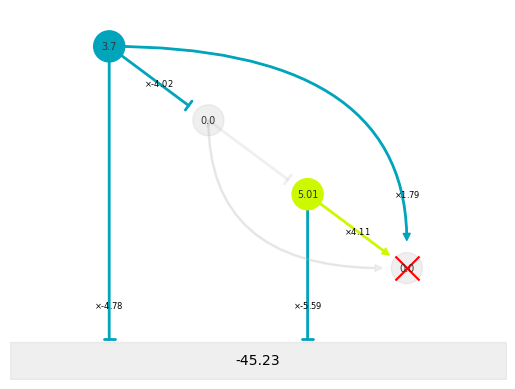

In [162]:
fig, ax = plt.subplots()

models[7433].plot(ax)

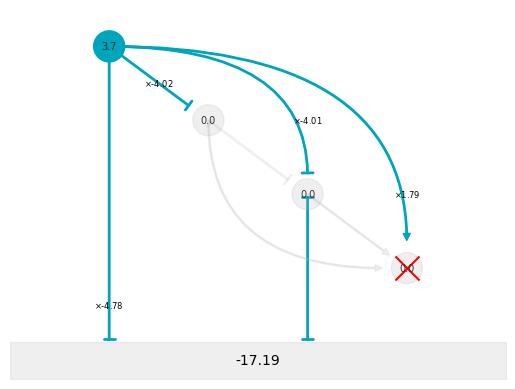

In [163]:
fig, ax = plt.subplots()

models[7352].plot(ax)

In [134]:
dat[dat.loc[:, ""] == "C+LOO"].feat.value_counts()

0     2253
2     1725
3     1634
6     1035
1      916
4      730
9      293
8       58
12       6
Name: feat, dtype: int64

In [135]:
dat[dat.loc[:, ""] == "PB"].feat.value_counts()

0     4910
2     2819
1     1662
3     1660
4     1217
6     1026
9       98
8       96
12      10
Name: feat, dtype: int64

In [127]:
dat[dat.loc[:, ""] == "C+LOO"].loc[:, feat].mean()

n_edges        4.201618
n_path         2.422312
edge_hetero    0.887837
n_bimodal      1.767746
n_sep          1.465665
feat           2.493757
dtype: float64

In [128]:
dat[dat.loc[:, ""] == "PB"].loc[:, feat].mean()

n_edges        3.677286
n_path         2.736479
edge_hetero    0.896739
n_bimodal      1.656690
n_sep          1.575567
feat           1.857609
dtype: float64

In [96]:
dat[dat.loc[:, ""] == "C+LOO"].sort_values("pb")

,cloo,pb,,label,n_edges,n_path,edge_hetero,n_bimodal,feat
52361,1.0,-0.500000,C+LOO,1,4,3,0.699854,2,2
26846,1.0,-0.500000,C+LOO,1,4,2,1.000000,3,6
7163,1.0,-0.500000,C+LOO,1,4,3,0.989743,4,4
32678,1.0,-0.500000,C+LOO,1,4,2,0.745356,2,4
15236,1.0,-0.333333,C+LOO,1,6,4,0.979796,4,0
...,...,...,...,...,...,...,...,...,...
2879,1.0,0.750000,C+LOO,1,4,3,0.989743,3,3
45779,1.0,0.750000,C+LOO,1,3,4,0.903508,1,0
13703,1.0,0.750000,C+LOO,1,3,4,0.989743,2,0
52478,1.0,0.750000,C+LOO,1,5,3,0.000000,0,0


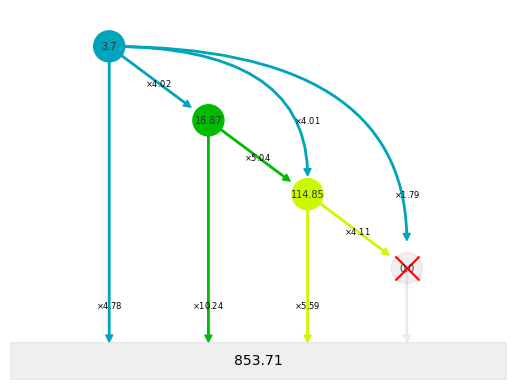

In [99]:
fig, ax = plt.subplots()

models[59045].plot(ax)

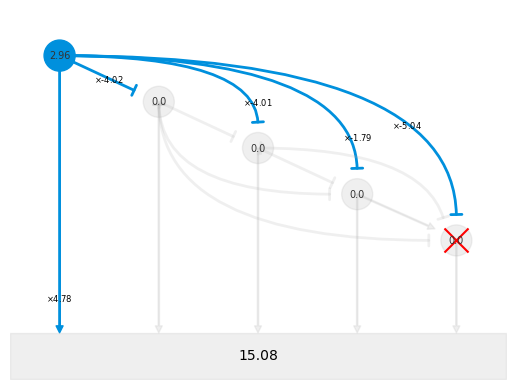

In [43]:
fig, ax = plt.subplots()

models[2].plot(ax)

In [44]:
ground_truth[2]

X1   -1
X2    0
X3   -1
X4    1
X5    0
dtype: int64

In [21]:
edges[2]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1])

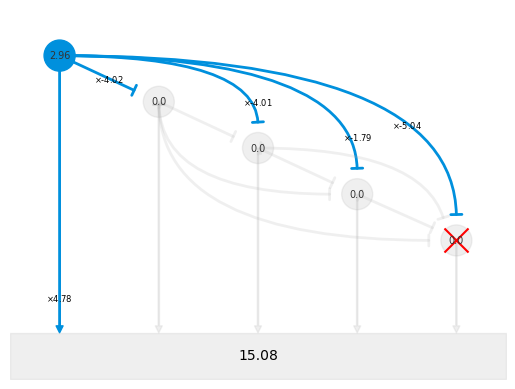

In [22]:
fig, ax = plt.subplots()

models[0].plot(ax)

In [23]:
def n_pathways(arr) -> int:
    return int(
        (np.abs(arr)[:4] == 0).all()
    ) + int(
        (np.abs(arr)[4:7] == 0).all()
    ) + int(
        (np.abs(arr)[7:9] == 0).all()
    ) + int(
        (np.abs(arr)[9:] == 0).all()
    ) + 1

In [141]:
(len(edges) - 1) / 2

29524.0

In [137]:
n_pathways(edges[0])

1

In [142]:
n_pathways(edges[29524])

5

In [135]:
int((np.abs(edges[0])[:4] == 0).all())

0

In [129]:
np.abs(edges[0]).sum()

10

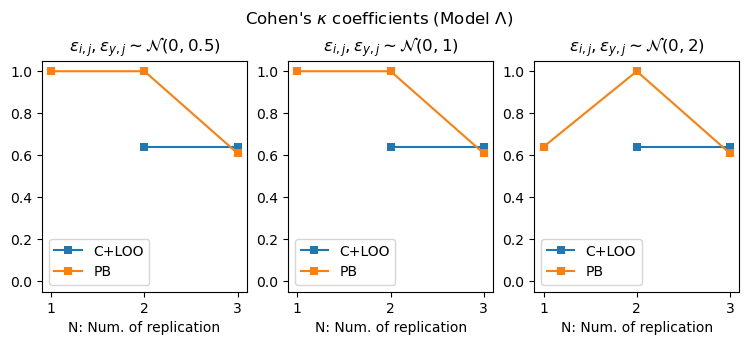

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df = pd.DataFrame({
    "n": n_arr * 3,
    "err": np.ravel([[v] * 3 for v in [.5, 1, 2]]),
    "pb_k": pb_k,
    "cloo_k": cloo_k,
    "pb_dd": pb_dd,
    "cloo_dd": cloo_dd,
})

for i, a in enumerate(ax.ravel()):
    e = df.err.unique()[i]
    sns.lineplot(
        data=df[df.err == e], x="n", y="cloo_k", marker="s", 
        ax=a, label=conditions["cloo"][0].metadata["design"], 
        markeredgewidth=0,
    )
    sns.lineplot(
        data=df[df.err == e], x="n", y="pb_k", marker="s", 
        ax=a, label=conditions["pb"][0].metadata["design"],
        markeredgewidth=0,
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="N: Num. of replication", ylabel="")
    a.legend(loc="best")

fig.suptitle(r"Cohen's $\kappa$" + f" coefficients ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks{conf.suffix}", **kwarg_savefig)

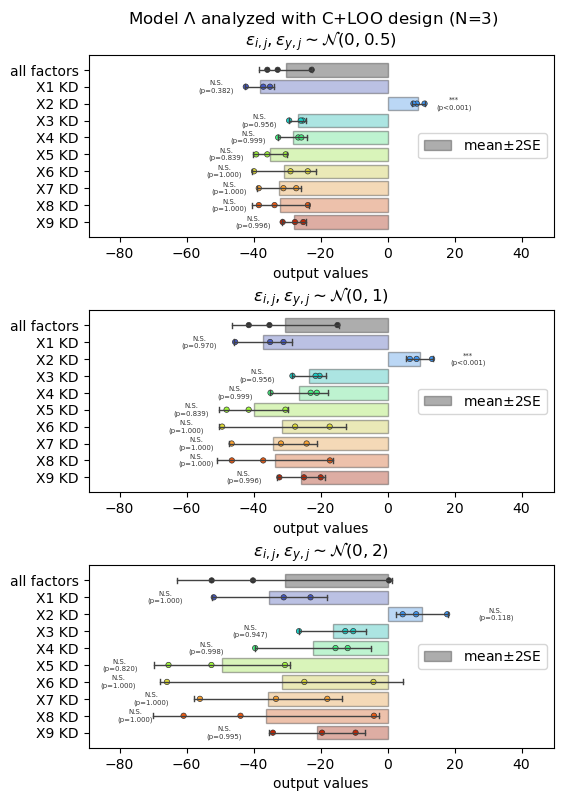

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
plt.subplots_adjust(hspace=.4)

for i, a in enumerate(ax.ravel()):
    model = conditions["cloo"][3 * i + 2]
    bio_multicomp(model, cmap=model.cmap, ax=a, text_kwargs={"size": 5}, xscales=[1.2, 2.2], jitter_ratio=.15)
    a.set_title(noise_names[i])

    # for x, y, t, c in zip([-160, 120], [0, 0], ["Upregulation", "Downregulation"], ["C3", "C0"]):
    #     a.text(x, y, t, color=c, ha="center", va="center", size=11)

    a.legend(loc="center right")

xlim = (lambda arr: [arr.min(), arr.max()])(np.array([a.get_xlim() for a in ax.ravel()]))

[a.set_xlim(*xlim) for a in ax.ravel()]
    
fig.suptitle(f"{conf.simulator().name} analyzed with {model.metadata['design']} design (N={model.metadata['n_rep']})", y=.93)

if conf.savefig:
    fig.savefig(f"{conf.out}/intuitive_plots_for_benchmarking{conf.suffix}", **kwarg_savefig)

In [11]:
n_add = [2, 6, 10]

doptims = dict(
    docloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_add)))
)

In [12]:
for i, m in enumerate(doptims["docloo"]):
    m.simulate(
        design=DOCLOO,
        n_rep=3,
        n_add = n_add[i % len(n_add)],
        model_kwargs=noise_conf[i // len(n_add)],
    )

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this wa

In [13]:
do_k = []

for do, gt in zip(doptims["docloo"], ground_truth):
    do_res = MLR(do).summary(anova=True, dtype=int)
    do_k += [kappa(do_res, gt)]

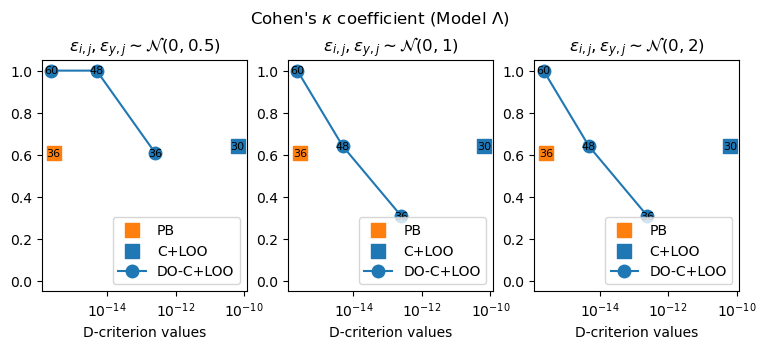

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df2 = pd.DataFrame({
    "nmax": [len(m.exmatrix) for m in doptims["docloo"]],
    "d": np.fromiter(
        map(
            d_criterion, 
            map(
                sm.add_constant, 
                [m.exmatrix for m in doptims["docloo"]]
            )
        ), 
        float
    ),
    "err": np.ravel([[v] * 3 for v in [.5, 1, 2]]),
    "do_k": do_k
})

d_pb = d_criterion(sm.add_constant(pb.exmatrix))
d_cloo = d_criterion(sm.add_constant(cloo.exmatrix))

for i, a in enumerate(ax.ravel()):
    e = df2.err.unique()[i]
    pb = conditions["pb"][3 * i + 2]
    cloo = conditions["cloo"][3 * i + 2]
    a.scatter(d_pb, pb_k[3 * i + 2], marker=",", color="C1", label="PB", s=100)
    a.scatter(d_cloo, cloo_k[3 * i + 2], marker=",", color="C0", label="C+LOO", s=100)
    sns.lineplot(
        data=df2[df2.err == e], x="d", y="do_k", marker="o", 
        ax=a, label="DO-C+LOO", 
        markeredgewidth=0, color="C0", markersize=10
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="D-criterion values", ylabel="")
    a.set_xscale("log")
    a.legend(loc="lower right")
    
    for x, y, t in zip(
        list(df2[df2.err == e].d) + [d_pb, d_cloo],
        list(df2[df2.err == e].do_k) + [pb_k[3 * i + 2], cloo_k[3 * i + 2]],
        list(df2[df2.err == e].nmax) + [len(pb.exmatrix), len(cloo.exmatrix)],
    ):
        a.text(x, y, t, ha="center", va="center", size=8)

fig.suptitle(r"Cohen's $\kappa$" + f" coefficient ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_with_do{conf.suffix}", **kwarg_savefig)